# Credit card fraud detection

This notebook will Exploratory Data Analysis on Credit Card Fraud dataset 


## Index  :- 

  1. Data Loading
  2. DataQuality Check 
  3. Descriptive Analysis
  4. Dependent Variable Analysis 
  5. Univariate Analysis
  6. Bivariate Analysis
  7. Modeling - Supervised & Unsupervised
      8.1 - HyperParameter Tuning
  8. Model Explainability 
  


In [1]:
!pip install -q -U scikit-learn
!pip install -q scikit-learn==0.22.1
!pip install -q eli5
!pip install -q shap
!pip install -q pdpbox

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
klib 0.1.5 requires scikit-learn>=0.23, but you have scikit-learn 0.22.1 which is incompatible.


In [4]:
# Importing the libraries

import warnings 
warnings.filterwarnings('ignore')

# libraries for visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.gridspec as gridspec
from collections import Counter
import plotly.offline as py
py.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt

# libraries for modelling
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report,accuracy_score, roc_curve, precision_score
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score, f1_score, precision_recall_curve
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest


# Model Explainability

import eli5
from eli5.sklearn import PermutationImportance
import shap
from pdpbox import pdp, get_dataset, info_plots

In [5]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
DATA_PATH="/content/gdrive/My Drive/Colab Notebooks/Interviews/2021_July_Digital_Katalis/data/"
data = pd.read_csv(DATA_PATH+"creditcard.csv")

In [8]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### <h3><font color=red>OBSERVATIONS</font></h3>

&#9658; **Due to confidentiality issue, original features V1, V2,... V28 have been transformed using PCA, however, my guess is that these features might be credit card number, expiry date, CVV, cardholder name, transaction location, transaction date-time, etc.**

&#9658; **Only features which have not been transformed with PCA are 'Time',&nbsp; 'Amount' and 'Class'.**<br>

> - **'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.**<br><br>
> - **The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning.**<br><br>
> - **The Feature 'Class' is the response or target variable and it takes value 1 in case of fraud and 0 otherwise.**<br>

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [10]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

&#9658; **We can clearly see that we don't have any null values in the data which is bound to happen in such datasets as each and every information is very necessary else the transaction isn't processed.**

<h3><font color=blue>Descriptive Statistics</font></h3>

&#9658; **As most of the columns V1, V2,... V28 are transformed using PCA so neither features make much sense and nor will the descriptive statistics so we will leave them and consider only Time and Amount which makes sense.**

In [11]:
data[['Time', 'Amount']].describe()

,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


<h3><font color=red>OBSERVATIONS</font></h3>

&#9658; **Mean transaction is somewhere is 88 and standard deviation is around 250.**<br><br>
&#9658; **The median is 22 which is very less as compared to mean which signifies that there are outliers or our data is highly positive skewed which is effecting the amount and thus the mean. High Skewness can be handled by using log transformation or boxcox transformation.**<br><br>
&#9658; **The maximum transaction that was done is of 25,691 and minimum is 0.**


> **Now, Let's try descriptive statistics filtering by fraudulent and non-fraudulent transactions.**

In [12]:
# Descriptive statistics of  of frauds transactions
configure_plotly_browser_state()

summary = (data[data['Class'] == 1].describe().transpose().reset_index())

summary = summary.rename(columns = {"index" : "feature"})
summary = np.around(summary,3)

val_lst = [summary['feature'], summary['count'],
           summary['mean'],summary['std'],
           summary['min'], summary['25%'],
           summary['50%'], summary['75%'], summary['max']]

trace  = go.Table(header = dict(values = summary.columns.tolist(),
                                line = dict(color = ['#506784']),
                                fill = dict(color = ['skyblue']),
                               ),
                  cells  = dict(values = val_lst,
                                line = dict(color = ['#506784']),
                                fill = dict(color = ["lightgrey",'#F5F8FF'])
                               ),
                  columnwidth = [150,60,100,100,80,80,80,80,80])
layout = go.Layout(dict(title = "Summary for fraudulent Transactions"))
figure = go.Figure(data=[trace],layout=layout)
py.iplot(figure)


In [13]:
# Descriptive statistics of geniune transactions

configure_plotly_browser_state()

summary = (data[data['Class'] == 0].describe().transpose().reset_index())

summary = summary.rename(columns = {"index" : "feature"})
summary = np.around(summary,3)

val_lst = [summary['feature'], summary['count'],
           summary['mean'],summary['std'],
           summary['min'], summary['25%'],
           summary['50%'], summary['75%'], summary['max']]

trace  = go.Table(header = dict(values = summary.columns.tolist(),
                                line = dict(color = ['#506784']),
                                fill = dict(color = ['lightgreen']),
                               ),
                  cells  = dict(values = val_lst,
                                line = dict(color = ['#506784']),
                                fill = dict(color = ["lightgrey",'#F5F8FF'])
                               ),
                  columnwidth = [130,100,100,100,80,80,80,80,80])
layout = go.Layout(dict(title = "Summary for Geniune Transactions"))
figure = go.Figure(data=[trace],layout=layout)
py.iplot(figure)


<h3 align="center"><font color=red>OBSERVATIONS</font></h3>

#### <font color=blue>FRAUDULENT</font>

>&#9658; **Mean transaction is around 122 and standard deviation is around 256.**<br><br>
>&#9658; **Maximum Transaction was 2125 and minimum was 0.**<br>

#### <font color=blue>NORMAL</font>

> &#9658; **Mean transaction is around 88 and standard deviation is around 250.**<br><br>
> &#9658; **Maximum Transaction was 25691 and minimum was 0.**<br>

In [14]:
# Percentages of fraudulent and non-fradulent transactions in data

print(f'Percent of Non-Fraudulent Transactions = {round(data["Class"].value_counts()[0]/len(data) * 100,3)}%')
print(f'Percent of Fraudulent Transactions = {round(data["Class"].value_counts()[1]/len(data) * 100,3)}%')

Percent of Non-Fraudulent Transactions = 99.827%
Percent of Fraudulent Transactions = 0.173%


In [15]:
# plotting a pie chart for fraud and non-fraud transactions
configure_plotly_browser_state()

fraud_or_not = data["Class"].value_counts().tolist()

labels = ['Not Fraud','Frauds']
values = [fraud_or_not[0], fraud_or_not[1]]
colors = ['skyblue', 'red']

trace = go.Pie(labels=labels, values=values, textinfo='value', 
               textfont=dict(size=20),
               marker=dict(colors=colors, line=dict(color='#000000', width=0.1)))

plotly.offline.iplot([trace], filename='styled_pie_chart')


<h3><font color=red>OBSERVATIONS</font></h3>
 
&#9658; **This dataset has 492 frauds out of 284,315 transactions. Thus, the dataset is highly unbalanced, the positive class (frauds) account for 0.173% of all transactions.**

&#9658; **Most of the transactions are non-fraud which is obvious. If we use this data for our predictive models and analysis, our algorithms will probably overfit to the non-fraudulent transactions and will answer in non-fraudulent all the time which can result in actual frauds to slip by!**

&#9658; **Note that our task is not to find the obvious, rather we have to find the anomalies and signs of fraud! Thus, we will take care of this imbalance during preprocessing.**

In [16]:
print('\n\033[1m  Fraudulent Transaction Distribution by amount \033[0m')
print("-"*50)
print(data[(data['Class'] == 1)]['Amount'].value_counts().head())


  Fraudulent Transaction Distribution by amount 
--------------------------------------------------
1.00     113
0.00      27
99.99     27
0.76      17
0.77      10
Name: Amount, dtype: int64


<h3><font color=red>OBSERVATIONS</font></h3>

&#9658; **There are 113 fraud transactions for just one dollar and 27 fraud transaction for 99.99 dollars. Also, there are 27 fraud transaction for zero amount.<br>**

&#9658; **The reason for zero transaction can be the Zero Authorization which is an account verification method for credit cards that is used to verify a cardholders information without charging the consumer.**

<h1><font color=red>Correlation of Features with Response</font></h1>

&#9658; **Let's plot the correlation of our response i.e Class with all the other features in the data.**

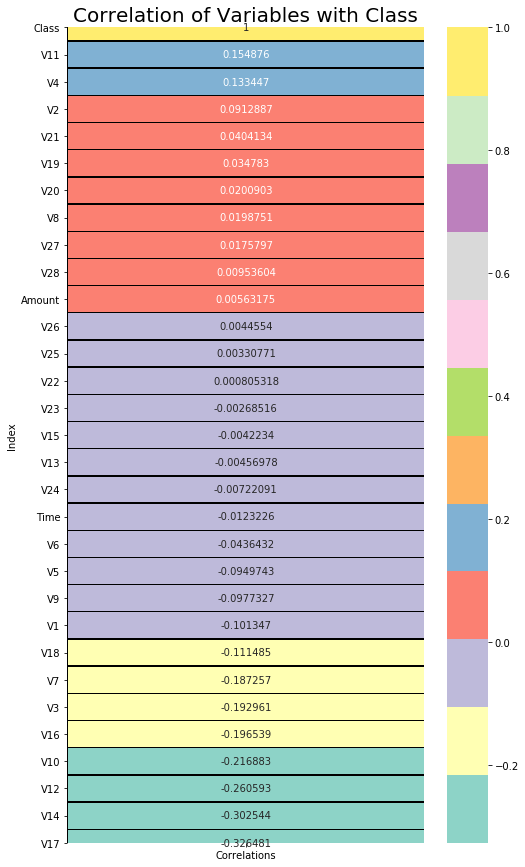

In [17]:
corr = data.corrwith(data['Class']).reset_index()

corr.columns = ['Index','Correlations']
corr = corr.set_index('Index')
corr = corr.sort_values(by=['Correlations'], ascending = False)

plt.figure(figsize=(8, 15))
fig = sns.heatmap(corr, annot=True, fmt="g", cmap='Set3', linewidths=0.4, linecolor='black')

plt.title("Correlation of Variables with Class", fontsize=20)
plt.show()

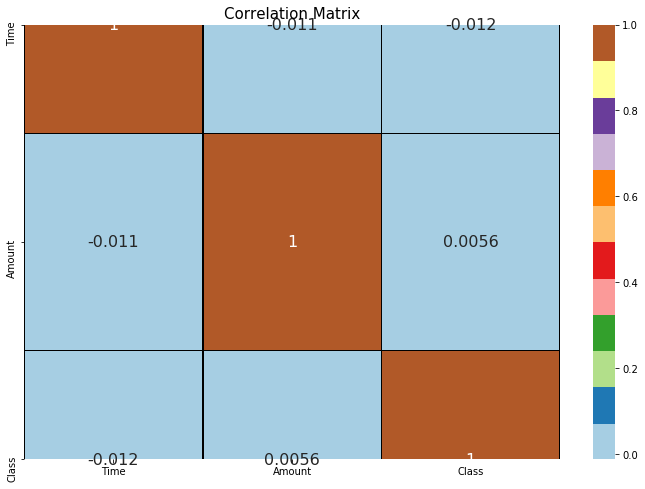

In [18]:
# Heatmap for explainatory variables

plt.subplots(figsize=(12,8))
plt.title("Correlation Matrix", fontsize=15)
sns.heatmap(data[['Time', 'Amount','Class']].corr(),linewidths=0.5, cmap="Paired", linecolor='black',annot=True, annot_kws={'size':16},);

&#9658; **V17, V14, V12 and V10 are negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraud transaction.**<br>


&#9658; **V2, V4, V11, and V19 are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction.**


&#9658; **Sadly, features that show correlation with response variable are not explainatory so we don't get much insights from this plot. But, we still have a lot to analyse so let's dive straight in!**

<h2><font color=red>Analysis of Time Column</font></h2>

<h3><font color=blue>Class vs Time</font></h3>

&#9658; **Let's plot the distribution of the classes with respect to time for both fraudulent and normal transactions.**

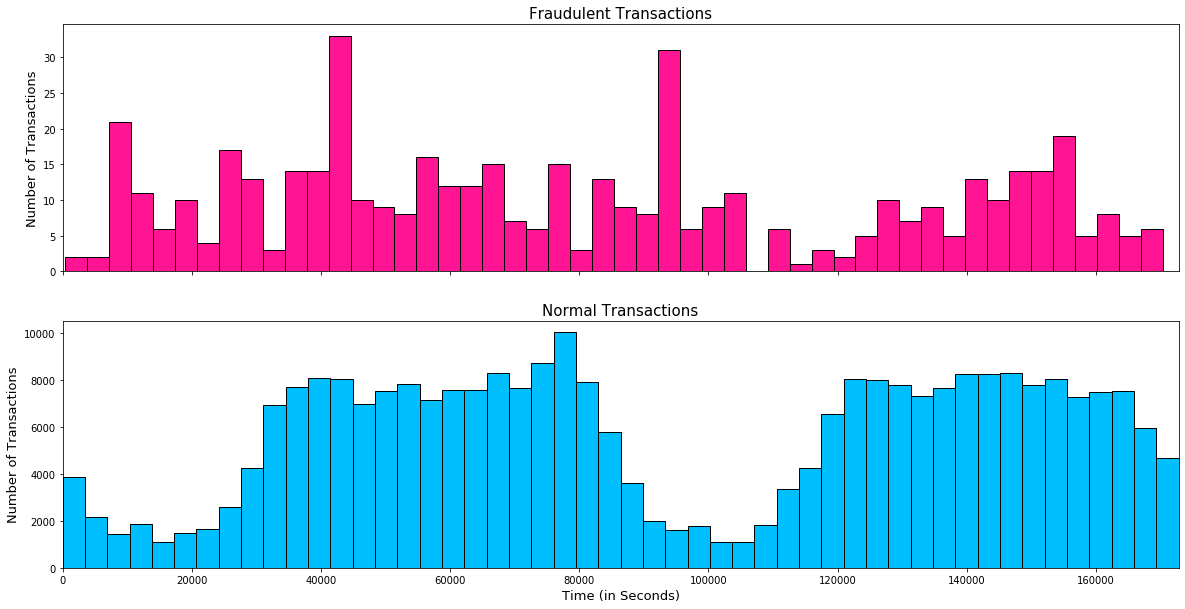

<h3 align="center"><font color=red>OBSERVATIONS</font></h3>

#### <font color=blue>FRAUDULENT</font>

>&#9658; **There are two peaks between 40000 seconds and 100000 seconds which were the maximum number of fraudulent transaction at any time.**


#### <font color=blue>NORMAL</font>

>&#9658; **Normal transactions have not much to uncover except the fact that there were less transactions somewhere around 20000 seconds and 100000 seconds which is not very useful.**

&#9658; **Let's do some feature engineering on time and transform it to minutes and hours to uncover some of the hidden patterns.**

In [20]:
# converting seconds to time delta to extract hours and mins

timedelta = pd.to_timedelta(data['Time'], unit='s')

data['mins'] = (timedelta.dt.components.minutes).astype(int)
data['hours'] = (timedelta.dt.components.hours).astype(int)

>&#9658; **Let's look at the distribution of number of transactions for each hour for total, fraudulent and normal transactions.**

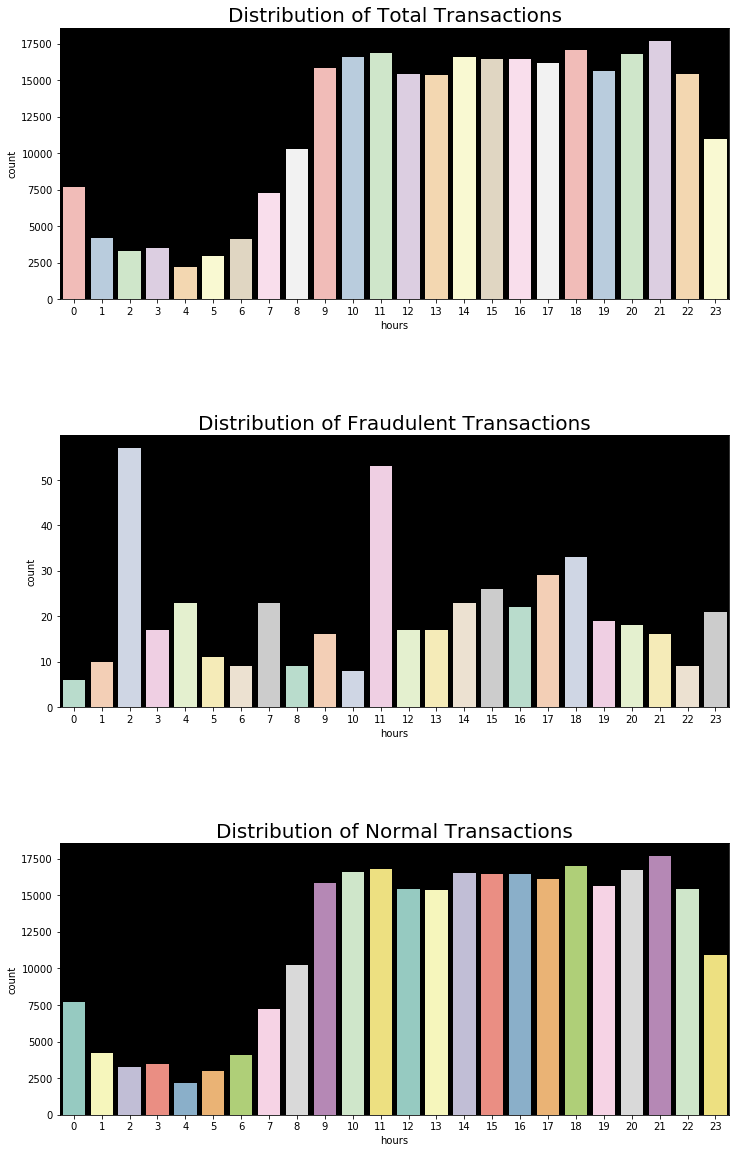

In [21]:
# Countplots for hours vs count of transactions
configure_plotly_browser_state()
fig, axs = plt.subplots(3, figsize=(12,20))

fig.subplots_adjust(hspace=.5)

sns.countplot(data['hours'], ax = axs[0], palette="Pastel1")
axs[0].set_title("Distribution of Total Transactions",fontsize=20)
axs[0].set_facecolor("black")

sns.countplot(data[(data['Class'] == 1)]['hours'], ax=axs[1], palette='Pastel2')
axs[1].set_title("Distribution of Fraudulent Transactions", fontsize=20)
axs[1].set_facecolor('black')

sns.countplot(data[(data['Class'] == 0)]['hours'], ax=axs[2], palette='Set3')
axs[2].set_title("Distribution of Normal Transactions", fontsize=20)
axs[2].set_facecolor("black")

plt.show()

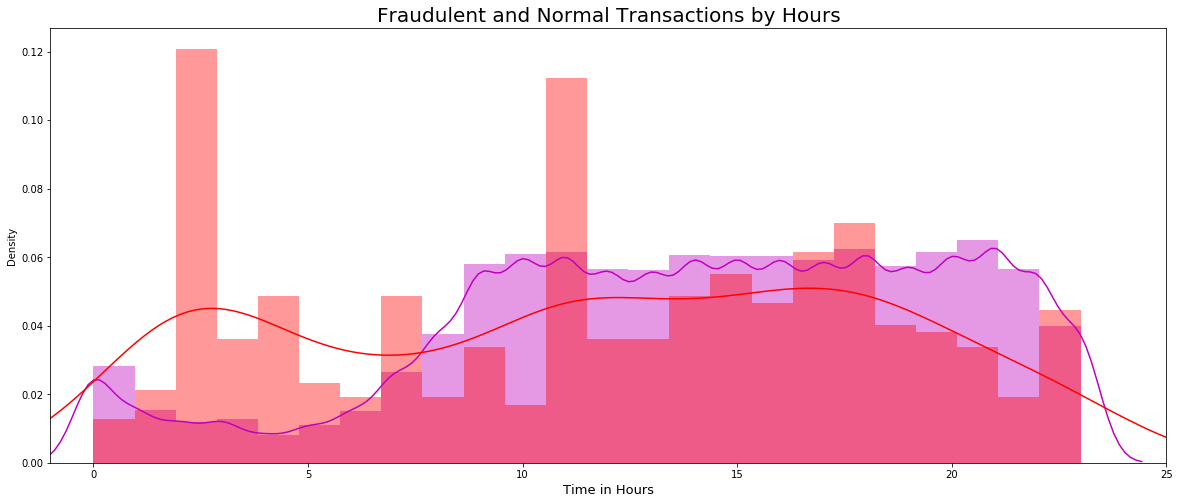

In [22]:
# Exploring the distribuition by Class types throught hours and minutes
configure_plotly_browser_state()

plt.figure(figsize=(20,8))

sns.distplot(data[data['Class'] == 0]['hours'], bins=24, color='m')
sns.distplot(data[data['Class'] == 1]["hours"], bins=24, color='r')

plt.title('Fraudulent and Normal Transactions by Hours', fontsize=20)

plt.xlabel("Time in Hours", fontsize=13)
plt.xlim([-1,25])
plt.show()

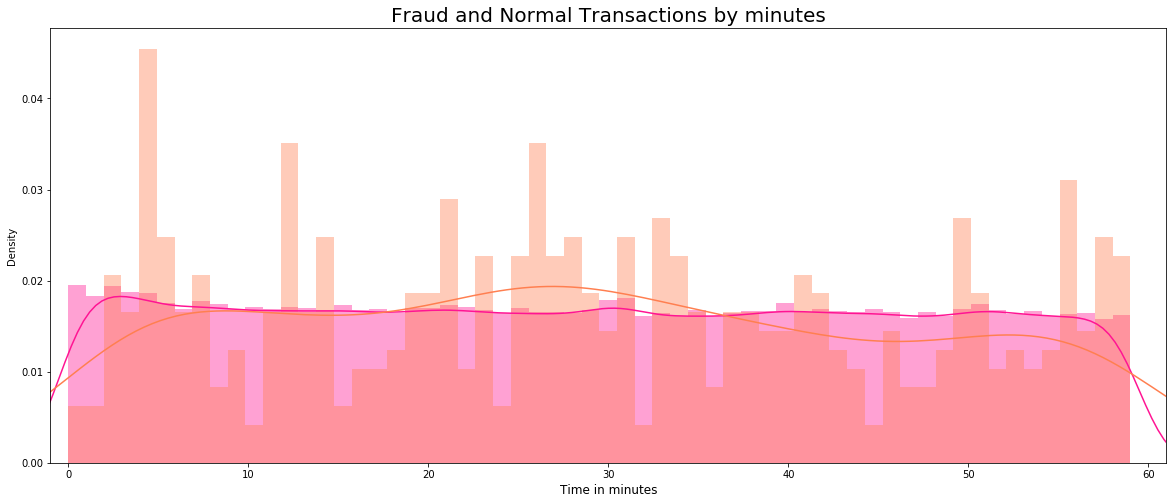

In [23]:
#Exploring the distribuition by Class types throught hours and minutes

plt.figure(figsize=(20,8))

sns.distplot(data[data['Class'] == 0]["mins"], bins =60, color='deeppink')
sns.distplot(data[data['Class'] == 1]["mins"], bins =60, color='coral')

plt.title('Fraud and Normal Transactions by minutes', fontsize=20)
plt.xlim([-1,61])
plt.xlabel("Time in minutes", fontsize=12)
plt.show()

<h3><font color=red>OBSERVATIONS</font></h3>

&#9658; **The plots of both hours and minutes doesn't have any interesting trend.**

<h3><font color=blue>Class and Amount vs Time</font></h3>

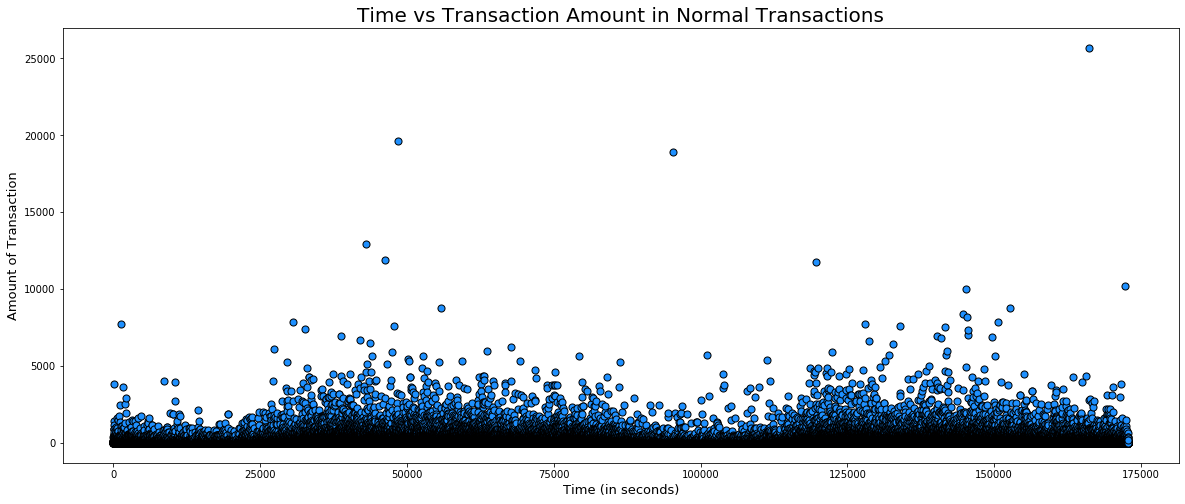

In [24]:
# Scatter plot of Class vs Amount and Time for Normal Transactions 
configure_plotly_browser_state()
plt.figure(figsize=(20,8))

fig = plt.scatter(x=data[data['Class'] == 0]['Time'], y=data[data['Class'] == 0]['Amount'], color="dodgerblue", s=50, edgecolor='black')
plt.title("Time vs Transaction Amount in Normal Transactions", fontsize=20)
plt.xlabel("Time (in seconds)", fontsize=13)
plt.ylabel("Amount of Transaction", fontsize=13)

plt.show()

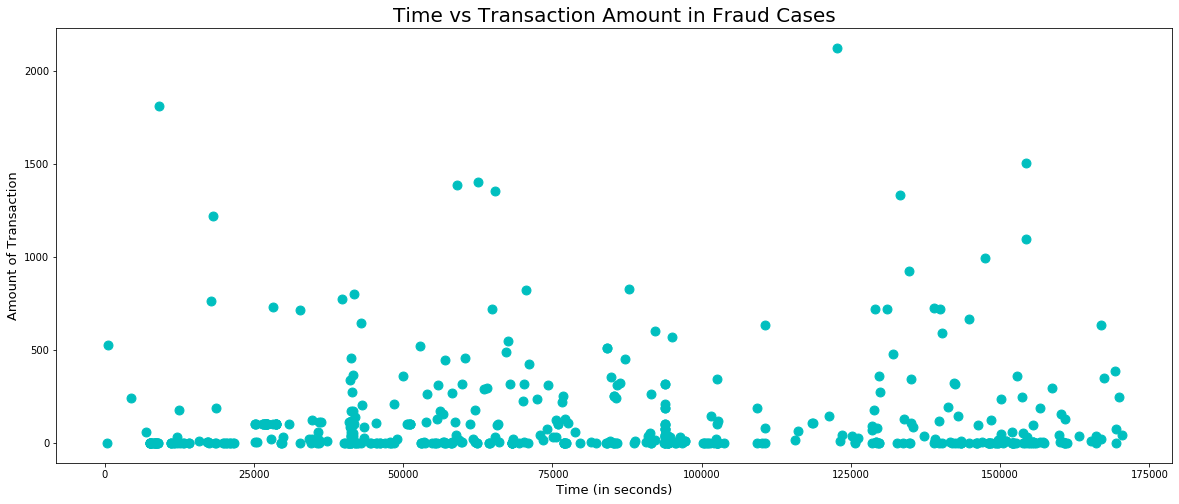

In [25]:
# Scatter plot of Class vs Amount and Time for Fraudulent Transactions 

plt.figure(figsize=(20,8))

fig = plt.scatter(x=data[data['Class'] == 1]['Time'], y=data[data['Class'] == 1]['Amount'], color="c", s=80)
plt.title("Time vs Transaction Amount in Fraud Cases", fontsize=20)
plt.xlabel("Time (in seconds)", fontsize=13)
plt.ylabel("Amount of Transaction", fontsize=13)

plt.show()

<h3 align="center"><font color=red>OBSERVATIONS</font></h3>

#### <font color=blue>FRAUDULENT</font>

>&#9658; **There are much more outliers as compared to normal transactions.**<br><br>
>&#9658; **The plot seems to not have any inherent pattern.**<br><br>

#### <font color=blue>NORMAL</font>

> &#9658; **There are a less number of outliers as compared to fraudulent transactions.**<br><br>
> &#9658; **There are a lot of transactions with amount less than 5000.**<br>

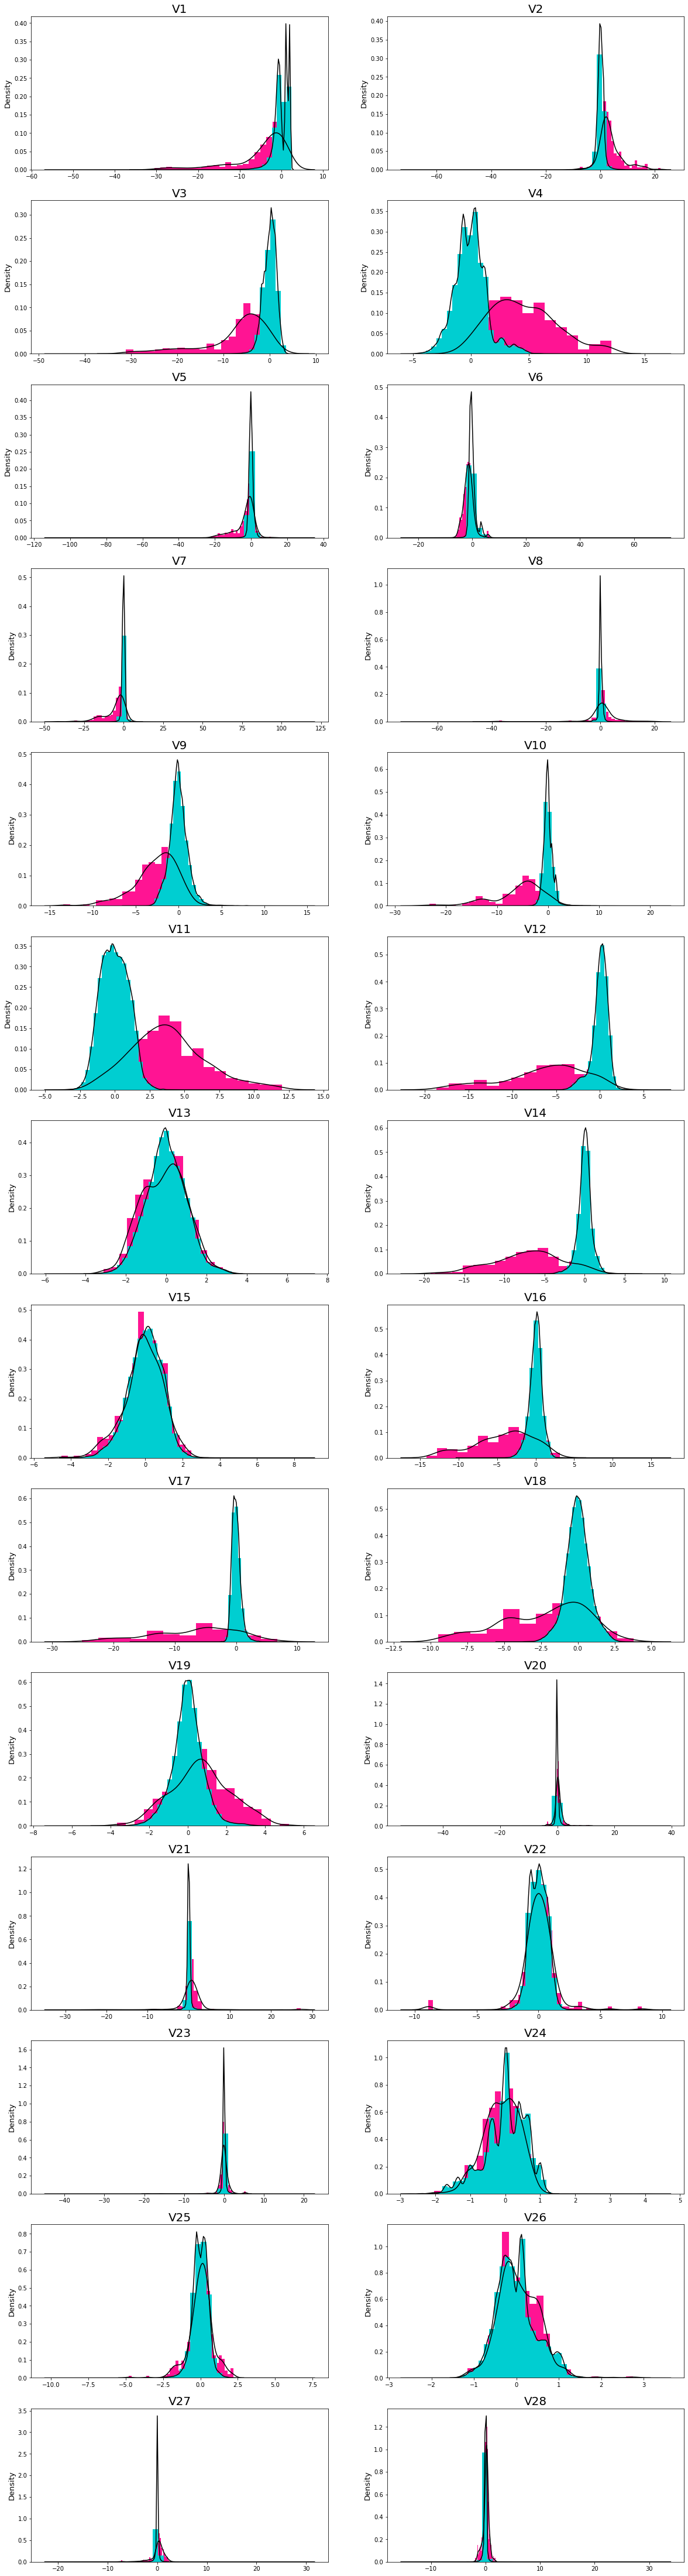

In [26]:
#Looking the V's features
columns = data.iloc[:,1:29].columns

frauds = data.Class == 1
normals = data.Class == 0

grid = gridspec.GridSpec(14, 2)
plt.figure(figsize=(20,20*4))

for n, col in enumerate(data[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(data[col][frauds], color='deeppink', kde_kws={"color": "k", "lw": 1.5},  hist_kws=dict(alpha=1)) 
    sns.distplot(data[col][normals],color='darkturquoise', kde_kws={"color": "k", "lw": 1.5},  hist_kws=dict(alpha=1))
    ax.set_ylabel('Density', fontsize=13)
    ax.set_title(str(col), fontsize=20)
    ax.set_xlabel('')
plt.show()

<h3><font color=red>OBSERVATIONS</font></h3>

&#9658; **For some of the features we can observe a good selectivity in terms of distribution for the two values of Class: V4, V11 have clearly separated distributions for Class values 0 and 1, V12, V14, V18 are partially separated, V1, V2, V3, V10 have a quite distinct profile, whilst V20-V28 have similar profiles for the two values of Class and thus not very useful in differentiation of both the classes.**

&#9658; **In general, with just few exceptions (Time and Amount), the features distribution for legitimate transactions (values of Class = 0) is centered around 0, sometime with a long queue at one of the extremities. In the same time, the fraudulent transactions (values of Class = 1) have a skewed (asymmetric) distribution.**

In [27]:
# copy of data for future use

temp = data.copy()

<h1><font color=red>Data Cleaning and Preprocessing</font></h1>

<h2><font color=blue>Outlier Removal</font></h2>

&#9658; **As we already saw that amount column has a extreme outliers so it necessary to remove them as they can effect the model's performance. We will used Interquartile range to detect outliers which removes anything below the lower limit (25 percentile) and anything above upper limit (75 Percentile).**

&#9658; **Note that, the data we have for fraudulent cases is very low so we wanna keep our cutoff a bit high so as avoid removing much of the fraud cases. Here, as the data is skewed (kind of exponential) so having high cutoff will help us. Let's take the cutoff value as 5.0 instead of 1.5 which is usually used.**

In [28]:
# Finding the 3rd and 1st Quantile for Amount Column

Q3 = np.percentile(data['Amount'], 75)
Q1 = np.percentile(data['Amount'], 25)

# setting the cutoff
cutoff = 5.0

# computing the interquartile range
IQR = (Q3 - Q1)

# computing lower bound and upper bound
lower_bound = Q1 - (IQR * cutoff)
upper_bound = Q3 + (IQR * cutoff)

# creating a filter to remove values less than lower bound and greater than
# upper bound
filter_data = (data['Amount'] < lower_bound) | (data['Amount'] > upper_bound)

# filtering data
outliers = data[filter_data]['Amount']
fraud_outliers = data[(data['Class'] == 1) & filter_data]['Amount']
normal_outliers = data[(data['Class'] == 0) & filter_data]['Amount']

print(f"Total Number of Outliers : {outliers.count()}")
print(f"Number of Outliers in Fraudulent Class : {fraud_outliers.count()}")
print(f"No of Outliers in Normal Class : {normal_outliers.count()}")
print(f"Percentage of Fraud amount outliers : {round((fraud_outliers.count()/outliers.count())*100,2)}%")

Total Number of Outliers : 11366
Number of Outliers in Fraudulent Class : 41
No of Outliers in Normal Class : 11325
Percentage of Fraud amount outliers : 0.36%


In [29]:
# dropping the outliers

data = data.drop(outliers.index)
data.reset_index(inplace=True, drop=True)

In [30]:
data.shape

(273441, 33)

> &#9658; **We have successfully removed the outliers now let's scale the Amount feature so that our model isn't baised towards amount feature which will also account for the skewness in the data.**

<h2><font color=blue>Feature Scaling</font></h2>

&#9658; **As the amount column is highly skewed so it will be better to apply log transoformation as it can result in nearly normal distribution which is suited for most of the algorithms.**

In [31]:
# applying log transformation of Amount column

data['Amount'] = np.log(data['Amount'] + 0.001)

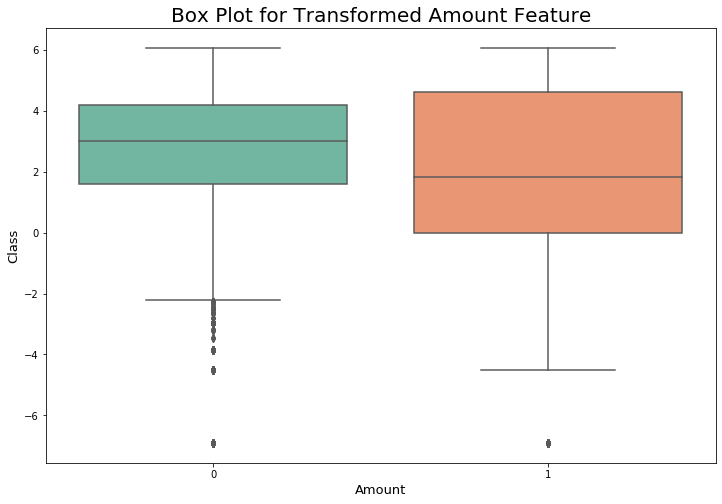

In [32]:
# Box Plot for transformed Amount feature with class

plt.figure(figsize=(12,8))
sns.boxplot(x ="Class", y="Amount", data=data, palette='Set2');
plt.xlabel("Amount", fontsize=13)
plt.ylabel("Class", fontsize=13)
plt.title("Box Plot for Transformed Amount Feature", fontsize=20);

>&#9658; **Now let's scale the time column but we will use normal scaling this time.**

In [33]:
# scaling the time column

robust_scaler = RobustScaler()
data['Time'] = robust_scaler.fit_transform(data['Time'].values.reshape(-1,1))

<h2><font color=blue> Handling Class Imbalance </font></h2>

&#9658; **Imbalanced data is a problem in supervised learning problems which can result is high bias towards majority class. As we have already seen that this data is severly imbalanced so to balance it we can use various techniques such as:** 

- **Oversampling**
- **Undersampling** 
- **SMOTE**

&#9658; **Out of all these three SMOTE is the most effective so we will go with it, In this technique, instead of simply duplicating data from the minority class, we synthesize new data from the minority class. This is a type of data augmentation for tabular data can be very effective. This approach to synthesizing new data is called the Synthetic Minority Oversampling TEchnique, or SMOTE for short.**

In [34]:
# Divide into X and Y after removing useless columns

X = data.drop(['Class','hours','mins'], 1)
Y = data.Class

In [35]:
# Apply SMOTE

print(f'Original dataset shape : {Counter(Y)}')

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, Y)

print(f'Resampled dataset shape {Counter(y_res)}')

Original dataset shape : Counter({0: 272990, 1: 451})
Resampled dataset shape Counter({0: 272990, 1: 272990})


>&#9658; **We can clearly see that now the data is completely balanced so let's use some visualisation technique to visualize this data.**

<h2><font color=blue> Splitting the data </font></h2>

&#9658; **As our data is imbalanced so we will not use train_test_split and instead we will use stratified split which will take the representative of respective populations i.e Fraud Transactions and Normal Transactions.**

In [63]:
# creating instance of statrifiedkfold split for 5 splits 
strat = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

# splitting the data
for train_index, test_index in strat.split(X, Y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = Y.iloc[train_index], Y.iloc[test_index]

Train: [ 29350  29392  29422 ... 273438 273439 273440] Test: [    0     1     2 ... 54742 54743 54744]
Train: [     0      1      2 ... 273438 273439 273440] Test: [ 29350  29392  29422 ... 109415 109416 109417]
Train: [     0      1      2 ... 273438 273439 273440] Test: [ 76259  76295  76304 ... 164124 164125 164126]
Train: [     0      1      2 ... 273438 273439 273440] Test: [144542 144548 144549 ... 218769 218770 218771]
Train: [     0      1      2 ... 218769 218770 218771] Test: [203831 204371 204395 ... 273438 273439 273440]


In [65]:
train_cols = original_Xtrain.columns

In [66]:
# Turning the splits into an array

original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

<h1><font color=red> Modelling </font></h1>

&#9658; **We will finally apply models and classify whether a certain transaction done a particular time is fraud or geniune. Thus, this is a binary classification problem.**

&#9658; **Important thing to note here is that we did SMOTE but we won't use that data, Why?**

**If we used that data to predict the classes then it will result in a problem know as 'Data Leakage' which is another term for using test data for prediction or cross validation. So, this sounds like a good point to use Pipelines. Pipelines make our life easier by specifying what order should the operations be done on the data.**

&#9658; **One thing we should keep in mind that we might get very high accuracy but we should focus on optimising out f1_score and recall as we want to perform better on fraud cases as they are the most important.**

In [38]:
# Creating a utility function to plot correlation matrix and roc_auc_curve

def show_metrics(model, y_test, y_pred):
    fig = plt.figure(figsize=(20, 8))

    # Confusion matrix
    ax = fig.add_subplot(121)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, annot_kws={"size": 16}, fmt='g', 
                cmap='Set3', linewidths=1, linecolor='white')

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels', fontsize=15);
    ax.set_ylabel('True labels', fontsize=15); 
    ax.set_title("Confusion Matix", fontsize=20) 
    ax.xaxis.set_ticklabels(['No Fraud', 'Fraud'], fontsize=12); 
    ax.yaxis.set_ticklabels(['Fraud', 'No Fraud'], fontsize=12);

    # ROC Curve
    fig.add_subplot(122)
    
    
    auc_roc = roc_auc_score(y_test, model.predict(original_Xtest))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(original_Xtest)[:,1])

    plt.plot(fpr, tpr, color='darkturquoise', lw=2, marker='o', label='Trained Model (area = {0:0.3f})'.format(auc_roc))
    plt.plot([0, 1], [0, 1], color='deeppink', lw=2, linestyle='--', label= 'No Skill (area = 0.500)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.title('Receiver operating characteristic', fontsize=20)
    plt.legend(loc="lower right")
    plt.show()

<h2><font color=blue> Logistic Regression </font></h2>

&#9658; **Let's start off with a simple model like Linear Regression. Note that I will be doing cross validation using Randomized search as the data is very huge and we will do this cross validation after splitting to avoid Data Leakage as discussed above.**

In [39]:
# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# specifying the parameter grid for logistic regression
log_reg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Applying RandomsearchCV to find best model
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# iterating over all the splits
for train, test in strat.split(original_Xtrain, original_ytrain):
    
    # create pipeline with smote and the model 
    # sampling_strategy = minority because we want to only resample the minority class
    pipeline = make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg)
    
    # fit the pipeline
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    # finding mean for all the necessary measures to evaluate performance
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))

print("Accuracy: {0:0.2f}%".format(np.mean(accuracy_lst)*100))
print("Precision: {0:0.2f}".format(np.mean(precision_lst)))
print("Recall: {0:0.2f}".format(np.mean(recall_lst)))
print("f1 Score: {0:0.2f}".format(np.mean(f1_lst)))

Accuracy: 97.53%
Precision: 0.07
Recall: 0.91
f1 Score: 0.13


In [40]:
# predict on test set
y_pred = best_est.predict(original_Xtest)

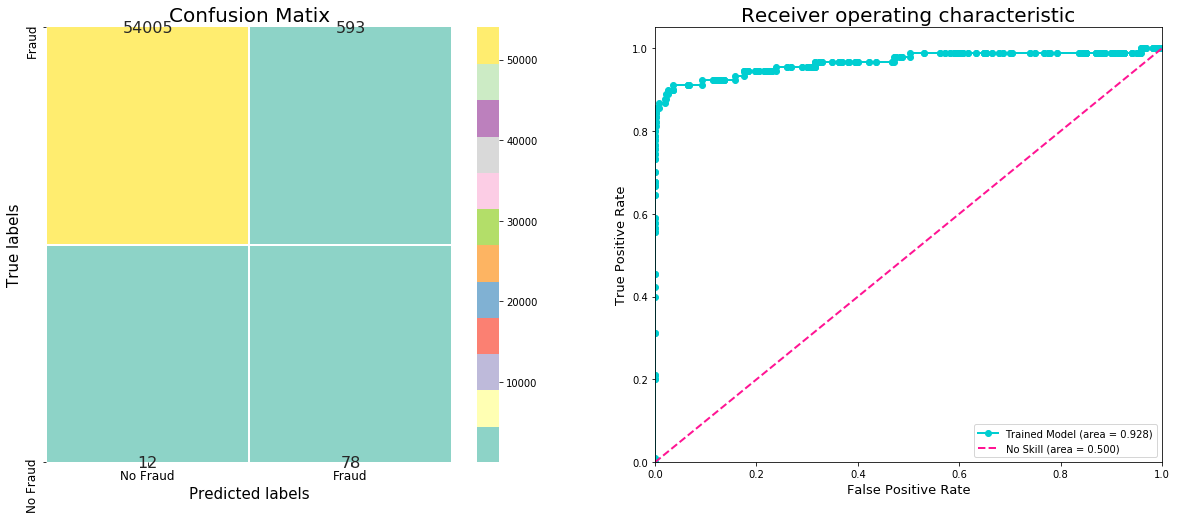

In [41]:
# plot confusion matrix and ROC curve

show_metrics(best_est, original_ytest, y_pred)

&#9658; **Logistic regression did really well on the fraud class giving almost 97.5% accuracy and algo does well on the fraud class, predicting 78 fraud cases are correct but 12 cases as wrong so we still have a room for improvement. It we applied model to the imbalanced data instead then it results would be pathetic. You can try that for yourself.**

<h2><font color=blue> Random Forest Classifier </font></h2>

&#9658; **Now, let's try something which can take account of complex realationships. There are many such models but Random forest is bit better as it is a ensemble model and focuses on reducing variance i.e overfitting without much effecting the bias which is all we want. Also, this algorithm works in time complexity, O(d.n.log(n)) where d is the number of features.**

&#9658; **I have shown the best parameters after GridsearchCV and not the whole process itself as it is very time consuming and takes forever so you can try it yourself.**

In [42]:
# Random forest Classifier
rf_cfl = RandomForestClassifier(n_estimators = 200, 
                                 max_features = 3, 
                                 min_samples_leaf = 1, 
                                 min_samples_split = 2, 
                                 n_jobs = -1,
                                random_state = 42)

rf_cfl.fit(original_Xtrain, original_ytrain)
y_pred = rf_cfl.predict(original_Xtest)

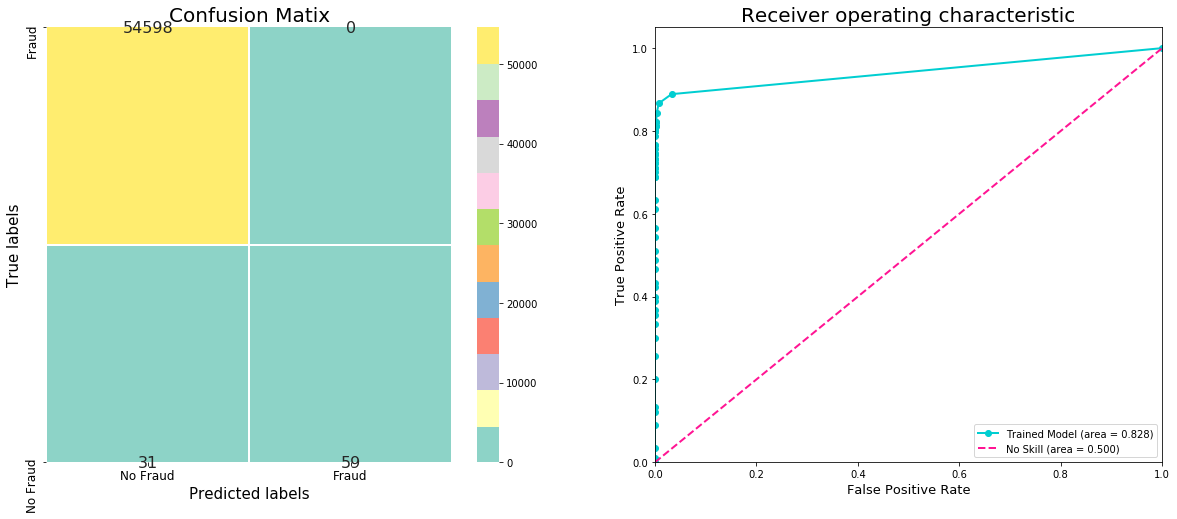

In [43]:
show_metrics(rf_cfl, original_ytest, y_pred)

In [44]:
print('Accuracy :{0:0.5f}'.format(accuracy_score(y_pred , original_ytest))) 
print('AUC : {0:0.5f}'.format(roc_auc_score(original_ytest , y_pred)))
print('Precision : {0:0.5f}'.format(precision_score(original_ytest , y_pred)))
print('Recall : {0:0.5f}'.format(recall_score(original_ytest , y_pred)))
print('F1 : {0:0.5f}'.format(f1_score(original_ytest , y_pred)))

Accuracy :0.99943
AUC : 0.82778
Precision : 1.00000
Recall : 0.65556
F1 : 0.79195


> &#9658; **Precision  and accuracy are good but the recall is pretty low due the which the model is not performing well on fraudulent data.**

<h2><font color=blue> HyperParameter Tuning </font></h2>

In [45]:
# Best model using ExtraTrees

accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

## Specifying the parameter grid for extra trees
extra_trees_params = {"n_estimators": [30,50,70,100], 'max_depth': [30,50,70,100], 'min_samples_split':[1,2,3,4,5]}

## Applying RandomsearchCV to find best model
rand_extra_trees = RandomizedSearchCV(ExtraTreesClassifier(random_state=42), extra_trees_params, n_iter=4)

## Iterating over all the splits
for train, test in strat.split(original_Xtrain, original_ytrain):
    
## Creating pipeline
  pipeline = make_pipeline(SMOTE(sampling_strategy='minority'), rand_extra_trees)
  model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
  best_est = rand_extra_trees.best_estimator_
  prediction = best_est.predict(original_Xtrain[test])
    
## Computing performance measures
  accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
  precision_lst.append(precision_score(original_ytrain[test], prediction))
  recall_lst.append(recall_score(original_ytrain[test], prediction))
  f1_lst.append(f1_score(original_ytrain[test], prediction))
  auc_lst.append(roc_auc_score(original_ytrain[test], prediction))

print("Accuracy: {0:0.2f}%".format(np.mean(accuracy_lst)*100))
print("Precision: {0:0.2f}".format(np.mean(precision_lst)))
print("Recall: {0:0.2f}".format(np.mean(recall_lst)))
print("f1 Score: {0:2f}".format(np.mean(f1_lst)))

Accuracy: 99.92%
Precision: 0.79
Recall: 0.82
f1 Score: 0.789746


&#9658; **Best Model : ExtraTreesClassifier(max_depth=50, n_estimators=70, min_samples_split=5, random_state=42)**

&#9658; **Results:** 

- **Accuracy: 99.92%**<br>
- **Precision: 0.79**<br>
- **Recall: 0.80**<br>
- **f1 Score: 0.78**<br>

In [46]:
# training using the best model

best_model = ExtraTreesClassifier(max_depth=50, n_estimators=70, min_samples_split=5, random_state=42)

In [47]:
fitted_model = best_model.fit(original_Xtrain, original_ytrain)

predictions = fitted_model.predict(original_Xtest)

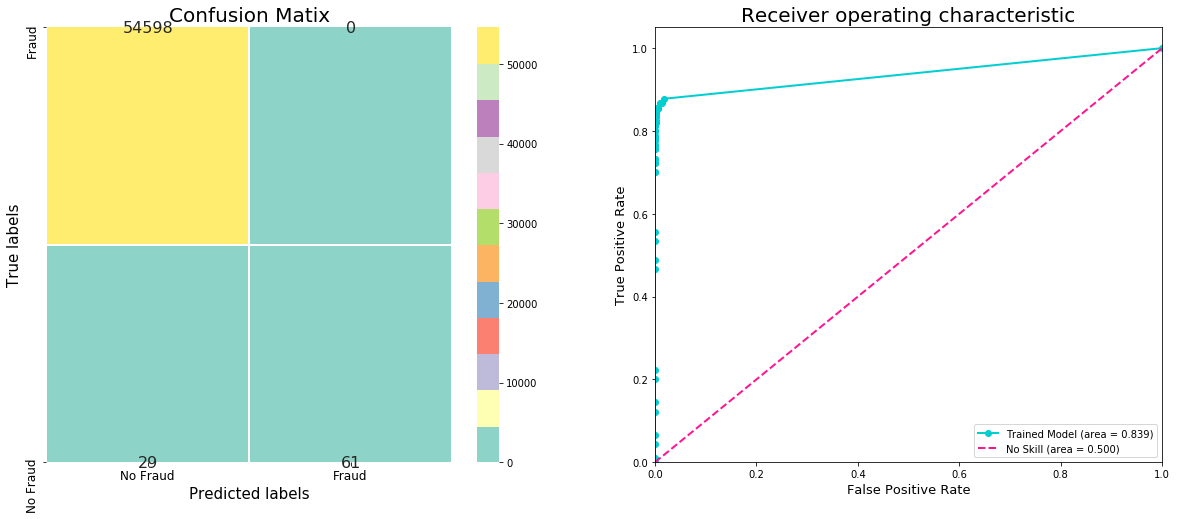

In [48]:
show_metrics(fitted_model, original_ytest, predictions)

> &#9658; **Using Extra Tree classifier we got 99.9% accuracy! But wait, let's look at the recall - only 80% which is even lower than our Logistic regression model. So, extra trees is performing bad on fraud data so let's try other models.**

<h2><font color=blue> Isolation Forest</font></h2>

&#9658; **Isolation Forest is an unsupervised anomaly detection algorithm that uses the two properties “Few” and “Different” of anomalies to detect their existence.**<br>

&#9658; **Since anomalies are few and different, they are more susceptible to isolation. This algorithm isolates each point in the data and splits them into outliers or inliers. This split depends on how long it takes to separate the points. If we try to separate a point which is obviously a non-outlier, it’ll have many points in its round, so that it will be really difficult to isolate. On the other hand, if the point is an outlier, it’ll be alone and we’ll find it very easily.**<br>


In [49]:
# utility function to compute accuracy of normal transactions
def normal_accuracy(values):
    
    tp=list(values).count(1)
    total=values.shape[0]
    accuracy=np.round(tp/total,4)
    
    return accuracy

# utility function to compute accuracy of fraud transactions
def fraud_accuracy(values):
    
    tn=list(values).count(-1)
    total=values.shape[0]
    accuracy=np.round(tn/total,4)
    
    return accuracy

&#9658; **Note that we will take the fresh data for performing anomaly detection. Also, we won't do outlier detection either, as out algorithm would already be doing that!**

In [50]:
# create inliers and outliers data

inliers = temp[temp.Class==0]
ins = inliers.drop(['Class'], axis=1)

outliers = temp[temp.Class==1]
outs = outliers.drop(['Class'], axis=1)


In [51]:
# training of isolation forest

ISF = IsolationForest(random_state=42)
ISF.fit(ins)

normal_isf = ISF.predict(ins)
fraud_isf = ISF.predict(outs)

in_accuracy_isf=normal_accuracy(normal_isf)
out_accuracy_isf=fraud_accuracy(fraud_isf)
print(f"Accuracy in Detecting Normal Cases: {in_accuracy_isf*100}%")
print(f"Accuracy in Detecting Fraud Cases: {round(out_accuracy_isf*100, 2)}%")

Accuracy in Detecting Normal Cases: 95.62%
Accuracy in Detecting Fraud Cases: 84.15%


&#9658; **Isolation forest successfully classified ~85% of the fraudulent transactions correction and it gives 96% on normal cases too which is pretty good.**

&#9658; **Let us give a final try by dropping some of the columns which we found useless during EDA. According to graphs, the correlation between amount and time is not very significant. Also, we saw some of the V's which were overlapping like crazy so they definately are of no help to use and can even lower down the accuracy. So, we will drop them and try our Isolation forest again on the new data.**

In [52]:
# dropping useless columns

new_data = temp.drop(['Time', 'Amount', 'V27', 'V28', 'V25', 'V23', 'V7', 'V13', 'V20','V22','mins','hours'], 1)

In [53]:
# create inliers and outliers data

inliers = new_data[new_data.Class==0]
ins = inliers.drop(['Class'], axis=1)

outliers = new_data[new_data.Class==1]
outs = outliers.drop(['Class'], axis=1)

In [54]:
# training of isolation forest on new data

ISF = IsolationForest(random_state=42)
ISF.fit(ins)

normal_isf = ISF.predict(ins)
fraud_isf = ISF.predict(outs)

in_accuracy_isf=normal_accuracy(normal_isf)
out_accuracy_isf=fraud_accuracy(fraud_isf)
print(f"Accuracy in Detecting Normal Cases: {in_accuracy_isf*100}%")
print(f"Accuracy in Detecting Fraud Cases: {out_accuracy_isf*100}%")

Accuracy in Detecting Normal Cases: 95.36%
Accuracy in Detecting Fraud Cases: 87.6%


&#9658; **This looks much better! We are doing pretty well on the fraud cases but we are now doing little less better on normal transactions which is fine as we are much more interested in Fraud Cases.**

&#9658; **I think we might be able to do much better using some stacking classifiers as they work on the errors of the previous models which can eventually increase the accuracy but I will leave that for you to try. So, do let me know!**

In [56]:
import matplotlib.pyplot as plt
import eli5
from eli5.sklearn import PermutationImportance
import shap
from pdpbox import pdp, get_dataset, info_plots

# Model Explainability

## Partial dependency of features
We've seen how randomizing the values of a column and estimating the loss to calculate the importance of features. We can also look at seeing how changing the values of a feature impacts the predictions.

### V4 feature
If the feature V4 has higher values, it has a higher change of being a case of fraud. You can see an increase in the y-axis as compared to a flat baseline in red.



In [73]:
rf_cfl1 = RandomForestClassifier(n_estimators = 200, 
                                 max_features = 3, 
                                 min_samples_leaf = 1, 
                                 min_samples_split = 2, 
                                 n_jobs = -1,
                                random_state = 42)

In [75]:
perm = PermutationImportance(rf_cfl1.fit(original_Xtrain,original_ytrain), random_state=1).fit(original_Xtrain,original_ytrain)

In [75]:
eli5.show_weights(perm, feature_names = X.columns.tolist(), top=(30))

Weight,Feature
0.0002 ± 0.0000,V14
0.0001 ± 0.0000,V4
0.0001 ± 0.0000,V17
0.0001 ± 0.0000,Amount
0.0001 ± 0.0000,V19
0.0001 ± 0.0000,V13
0.0000 ± 0.0000,V12
0.0000 ± 0.0000,V15
0.0000 ± 0.0000,V21
0.0000 ± 0.0000,V8


In [82]:
pi_features = eli5.explain_weights_df(perm, feature_names = X.columns.tolist())
pi_features = pi_features.loc[pi_features['weight'] >= 0.00005]['feature'].tolist()
print("\nFeatures from permutation importance", pi_features)


Features from permutation importance ['V14', 'V4', 'V17', 'Amount', 'V19', 'V13']
